In [22]:
import numpy as np 
import pandas as pd 
import os

In [23]:
PATH = r"C:\Users\tardi\OneDrive\Documenti\Università\Artificial Intelligence from enginnering to arts\Project\Datasets\DDSM + CBIS-DDSM\archive"

In [24]:
files = []

for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        files.append(os.path.join(dirname, filename))
        

C:\Users\tardi\OneDrive\Documenti\Università\Artificial Intelligence from enginnering to arts\Project\Datasets\DDSM + CBIS-DDSM\archive\cv10_labels.npy
C:\Users\tardi\OneDrive\Documenti\Università\Artificial Intelligence from enginnering to arts\Project\Datasets\DDSM + CBIS-DDSM\archive\test10_labels.npy
C:\Users\tardi\OneDrive\Documenti\Università\Artificial Intelligence from enginnering to arts\Project\Datasets\DDSM + CBIS-DDSM\archive\cv10_data\cv10_data.npy
C:\Users\tardi\OneDrive\Documenti\Università\Artificial Intelligence from enginnering to arts\Project\Datasets\DDSM + CBIS-DDSM\archive\test10_data\test10_data.npy
C:\Users\tardi\OneDrive\Documenti\Università\Artificial Intelligence from enginnering to arts\Project\Datasets\DDSM + CBIS-DDSM\archive\training10_0\training10_0.tfrecords
C:\Users\tardi\OneDrive\Documenti\Università\Artificial Intelligence from enginnering to arts\Project\Datasets\DDSM + CBIS-DDSM\archive\training10_1\training10_1.tfrecords
C:\Users\tardi\OneDrive\Do

In [12]:
from collections import Counter
import tensorflow as tf
import cv2
import glob
import skimage
import seaborn as sn
import preprocessing
from tqdm import tqdm
from io import BytesIO
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [25]:
# Création de listes vides pour stocker les images et les étiquettes.
images=[] 
labels=[]
# Création d'un dictionnaire de caractéristiques qui spécifie le type et la longueur des caractéristiques que nous allons extraire.
feature_dictionary = {  
    'label': tf.io.FixedLenFeature([], tf.int64),# La caractéristique 'label' est un entier 64 bits avec une longueur fixe.
    'label_normal': tf.io.FixedLenFeature([], tf.int64), # La caractéristique 'label_normal' est un entier 64 bits avec une longueur fixe.# La caractéristique 'label_normal' est un entier 64 bits avec une longueur fixe.
    'image': tf.io.FixedLenFeature([], tf.string)  # La caractéristique 'image' est une chaîne de caractères avec une longueur fixe.
    }

In [26]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example
# Fonction pour lire les données à partir d'un fichier TFRecord.
def read_data(filename):
    # Création d'un objet TFRecordDataset à partir du fichier.
    full_dataset = tf.data.TFRecordDataset(filename, num_parallel_reads=tf.data.experimental.AUTOTUNE)
    
    # Mélange du dataset.
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    
    # Mise en cache du dataset pour une lecture plus rapide.
    full_dataset = full_dataset.cache()
    
    # affichage de la taille du dataset.
    print("Size of Training Dataset: ", len(list(full_dataset)))

    # Application de la fonction _parse_function pour extraire les caractéristiques.
    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)

    # Boucle à travers chaque exemple dans le dataset.
    for image_features in full_dataset:
        # Extraction et décodage de l'image.
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299, 1])
        image = image.numpy()

        # Redimensionnement de l'image à (100, 100).
        image = cv2.resize(image, (100, 100))

        # Ajout de l'image à la liste des images.
        images.append(image)

        # Ajout de l'étiquette correspondante à la liste des étiquettes.
        labels.append(image_features['label_normal'].numpy())

In [32]:
# Liste de chemins de fichiers TFRecord contenant les données.
filenames=['../Datasets/DDSM + CBIS-DDSM/archive/training10_0/training10_0.tfrecords',
          '../Datasets/DDSM + CBIS-DDSM/archive/training10_1/training10_1.tfrecords',
          '../Datasets/DDSM + CBIS-DDSM/archive/training10_2/training10_2.tfrecords',
          '../Datasets/DDSM + CBIS-DDSM/archive/training10_3/training10_3.tfrecords',
          '../Datasets/DDSM + CBIS-DDSM/archive/training10_4/training10_4.tfrecords']

for file in filenames:
    read_data(file) # Itération sur chaque fichier dans la liste de chemins de fichiers.

# Affichage de la taille des listes d'images et d'étiquettes après le traitement de tous les fichiers.  
print(len(images))
print(len(labels))

Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None

In [33]:
# Convertit la liste 'images' en un tableau NumPy 'X'
X = np.array(images)

# Convertit la liste 'labels' en un tableau NumPy 'y'
y = np.array(labels)

# Divise les données en ensembles d'entraînement (x_train, y_train) et de test (x_test, y_test)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021, shuffle=True, stratify=y)

# Obtient les dimensions du tableau x_train (nombre d'échantillons, largeur, hauteur)
(a, b, c) = x_train.shape

# Affiche les dimensions du tableau x_train
print(x_train.shape)

# Redimensionne x_train pour ajouter une dimension supplémentaire correspondant à la chaîne de couleur (canal)
x_train = np.reshape(x_train, (a, b, c, 1))

# Obtient les dimensions du tableau x_test (nombre d'échantillons, largeur, hauteur)
(a, b, c) = x_test.shape

# Redimensionne x_test de la même manière que x_train
x_test = np.reshape(x_test, (a, b, c, 1))

(53649, 100, 100)


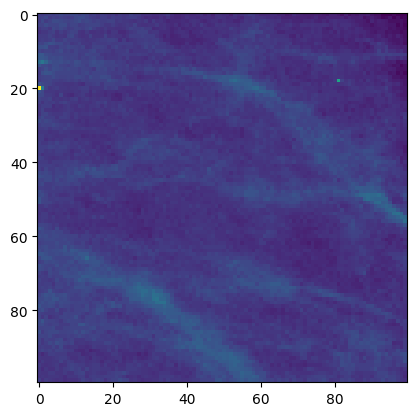

In [37]:
#  afficher une image du tableau x_train
plt.imshow(x_train[0])